In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os 
import sys
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)
import statistics as stats
from uncertainties import ufloat
import math

In [2]:
hdu = fits.open('/Users/quinncasey/Desktop/research/eboss/spLine_trim_dr16_eboss.fits')

In [3]:
ha = hdu[1].data['H_ALPHA_FLUX'].tolist()
ha_err = hdu[1].data['H_ALPHA_FLUX_ERR'].tolist()
hb = hdu[1].data['H_BETA_FLUX'].tolist()
hb_err = hdu[1].data['H_BETA_FLUX_ERR'].tolist()
o3 = hdu[1].data['OIII_5007_FLUX'].tolist()
o3_err = hdu[1].data['OIII_5007_FLUX_ERR'].tolist()
n2 = hdu[1].data['NII_6584_FLUX'].tolist()
n2_err = hdu[1].data['NII_6584_FLUX_ERR'].tolist()

z = hdu[1].data['Z'].tolist()

In [4]:
data_names = ['ha', 'ha_err', 'hb', 'hb_err', 'o3', 'o3_err', 'n2', 'n2_err', 'z']
data_dict = {'ha':ha, 'ha_err':ha_err, 'hb':hb, 'hb_err':hb_err, 'o3':o3, 
            'o3_err':o3_err, 'n2':n2, 'n2_err':n2_err, 'z':z}
df = pd.DataFrame(data_dict)

In [5]:
for name in data_names: 
    df = df.loc[df[name].notnull()]

In [6]:
df = df.loc[(df['ha']/df['ha_err']) > 3]
df = df.loc[(df['hb']/df['hb_err']) > 3]
df = df.loc[(df['n2']/df['n2_err']) > 3]
df = df.loc[(df['o3']/df['o3_err']) > 3]

df = df.query('z > 0.1 & z <=0.2')

In [7]:
def low_met_agn(df): 
    x_values = df.x.values
    y_values = df.y.values.tolist()
    
    z_1 = df['z'].values
    ha_1 = df['ha'].values
    ha_err_1 = df['ha_err'].values
    hb_1 = df['hb'].values
    hb_err_1 = df['hb_err'].values
    o3_1 = df['o3'].values
    o3_err_1 = df['o3_err'].values
    n2_1 = df['n2'].values
    n2_err_1 = df['n2_err'].values
    
    
    kewl_agn_class_line_mod = (0.61/(x_values-0.02-0.1833*(df.loc[:,"z"].median())))+1.4+0.03*(df.loc[:,"z"].median())
    
    df = []
    
    for x, y, agn_line in zip(x_values, y_values, kewl_agn_class_line_mod):
        if x < -0.8 and y > agn_line:
            df.append('lowmetagn')
        elif x >=-0.8 and y > agn_line:
            df.append('agn')
        elif x > 0.0:
            df.append('agn')
        else: 
            df.append('starform')
            
    return df, ha_1, ha_err_1, hb_1, hb_err_1, n2_1, n2_err_1, o3_1, o3_err_1, z_1

In [8]:
df['x'] = np.log10(df['n2']/df['ha'])
df['y'] = np.log10(df['o3']/df['hb'])

df1 = low_met_agn(df)

In [9]:
df1 = pd.DataFrame(df1)
df1 = df1.transpose()
df1.columns = ['Type', 'ha', 'ha_err', 'hb', 'hb_err', 'n2', 'n2_err', 'o3', 'o3_err', 'z']

In [10]:
dfagn = df1[df1.Type != 'starform']
dfsf = df1[df1.Type != 'agn']
dflowmetagn = df1[df1.Type != 'agn']

dfagn = dfagn[dfagn.Type != 'lowmetagn']
dfsf = dfsf[dfsf.Type != 'lowmetagn']
dflowmetagn = dflowmetagn[dflowmetagn.Type != 'starform']

In [11]:
print(len(dfagn))
print(len(dfsf))
print(len(dflowmetagn))

4057
7036
5


In [12]:
dfsf = dfsf.drop(columns=['ha', 'ha_err', 'hb', 'hb_err', 'n2', 'n2_err'])
dfagn = dfagn.drop(columns=['ha', 'ha_err', 'hb', 'hb_err', 'n2', 'n2_err'])
dflowmetagn = dflowmetagn.drop(columns=['ha', 'ha_err', 'hb', 'hb_err', 'n2', 'n2_err'])

In [13]:
d_MPC = cosmo.luminosity_distance(dflowmetagn['z'])
dflowmetagn['d (MPC)'] = d_MPC

In [14]:
d_MPC = cosmo.luminosity_distance(dfsf['z'])
dfsf['d (MPC)'] = d_MPC

In [15]:
d_MPC = cosmo.luminosity_distance(dfagn['z'])
dfagn['d (MPC)'] = d_MPC

In [16]:
dflowmetagn['d (cm)'] = dflowmetagn['d (MPC)']*3.08567758128E+24
dfsf['d (cm)'] = dfsf['d (MPC)']*3.08567758128E+24
dfagn['d (cm)'] = dfagn['d (MPC)']*3.08567758128E+24

In [17]:
def lumin(oxy3, d_cm):
    L = (oxy3)*(4)*(np.pi)*(d_cm**2)
    return L

In [18]:
dflowmetagn['luminosity_non_bolo'] = lumin(dflowmetagn['o3'], dflowmetagn['d (cm)'])
dfsf['luminosity_non_bolo'] = lumin(dfsf['o3'], dfsf['d (cm)'])
dfagn['luminosity_non_bolo'] = lumin(dfagn['o3'], dfagn['d (cm)'])

In [19]:
dflowmetagn['luminosity_non_bolo'] = dflowmetagn.luminosity_non_bolo.astype(float)
#dflowmetagn['luminosity_log10'] = np.log10(dflowmetagn['luminosity_non_bolo'])

dfsf['luminosity_non_bolo'] = dfsf.luminosity_non_bolo.astype(float)
#dflowmetagn['luminosity_log10'] = np.log10(dflowmetagn['luminosity_non_bolo'])

dfagn['luminosity_non_bolo'] = dfagn.luminosity_non_bolo.astype(float)
#dflowmetagn['luminosity_log10'] = np.log10(dflowmetagn['luminosity_non_bolo'])

In [20]:
def bolo_lumin(L_o3):
    L_iso_exp = ((0.5617)*(np.log10(L_o3)))+(22.186)
    #L_iso = np.log10(L_iso_exp)
    return L_iso_exp

In [21]:
bolo_non_log_lowmetagn = bolo_lumin(dflowmetagn['luminosity_non_bolo'])
dflowmetagn['log(bolo_lumin)'] = bolo_non_log_lowmetagn
bolo_lumin_lowmetagn = np.log10(bolo_non_log_lowmetagn)
dflowmetagn['Bolo_Lumin'] = bolo_lumin_lowmetagn

dflowmetagn['log(o3_lumin)'] = np.log10(dflowmetagn['luminosity_non_bolo'])
dflowmetagn

,Type,o3,o3_err,z,d (MPC),d (cm),luminosity_non_bolo,log(bolo_lumin),Bolo_Lumin,log(o3_lumin)
4387,lowmetagn,25.6281,1.4443,0.131985,620.396,1.91434e+27,1.180228e+57,54.243323,1.734346,57.071966
7356,lowmetagn,2024.96,17.3113,0.146862,696.87,2.15032e+27,1.176607e+59,55.365974,1.743243,59.070631
7381,lowmetagn,23.8116,1.03417,0.13071,613.898,1.89429e+27,1.073722e+57,54.220252,1.734162,57.030892
8285,lowmetagn,201.068,2.59995,0.170774,822.391,2.53763e+27,1.627086e+58,54.883349,1.739441,58.211411
9767,lowmetagn,28.4808,1.20441,0.110204,510.724,1.57593e+27,8.888649e+56,54.174161,1.733792,56.948836


In [22]:
bolo_non_log_sf = bolo_lumin(dfsf['luminosity_non_bolo'])
dfsf['log(bolo_lumin)'] = bolo_non_log_sf
bolo_lumin_sf = np.log10(bolo_non_log_sf)
dfsf['Bolo_Lumin'] = bolo_lumin_sf

dfsf['log(o3_lumin)'] = np.log10(dfsf['luminosity_non_bolo'])
dfsf

,Type,o3,o3_err,z,d (MPC),d (cm),luminosity_non_bolo,log(bolo_lumin),Bolo_Lumin,log(o3_lumin)
0,starform,96.7307,2.1615,0.105281,486.318,1.50062e+27,2.737254e+57,54.448540,1.735986,57.437315
1,starform,104.004,1.84497,0.199954,979.796,3.02334e+27,1.194632e+58,54.807982,1.738844,58.077234
2,starform,14.1594,1.20499,0.105692,488.35,1.50689e+27,4.040352e+56,53.981826,1.732248,56.606419
3,starform,46.8897,1.06865,0.131985,620.398,1.91435e+27,2.159382e+57,54.390693,1.735525,57.334329
4,starform,166.473,2.98074,0.10516,485.717,1.49877e+27,4.699187e+57,54.580375,1.737037,57.672023
...,...,...,...,...,...,...,...,...,...,...
11092,starform,16.0746,1.30638,0.179001,866.307,2.67315e+27,1.443428e+57,54.292432,1.734739,57.159395
11093,starform,48.4453,1.86179,0.112364,521.473,1.6091e+27,1.576254e+57,54.313907,1.734911,57.197626
11094,starform,4.32838,1.34999,0.185585,901.717,2.78241e+27,4.210922e+56,53.991913,1.732329,56.624377
11095,starform,99.3196,1.51987,0.132279,621.893,1.91896e+27,4.595975e+57,54.574958,1.736993,57.662378


In [23]:
bolo_non_log_agn = bolo_lumin(dfagn['luminosity_non_bolo'])
dfagn['log(bolo_lumin)'] = bolo_non_log_agn
bolo_lumin_agn = np.log10(bolo_non_log_agn)
dfagn['Bolo_Lumin'] = bolo_lumin_agn

dfagn['log(o3_lumin)'] = np.log10(dfagn['luminosity_non_bolo'])
dfagn

,Type,o3,o3_err,z,d (MPC),d (cm),luminosity_non_bolo,log(bolo_lumin),Bolo_Lumin,log(o3_lumin)
44,agn,8.03757,1.52481,0.119253,555.953,1.71549e+27,2.972428e+56,53.906947,1.731645,56.473111
48,agn,12.0597,2.08892,0.108069,500.122,1.54321e+27,3.609107e+56,53.954291,1.732026,56.557400
49,agn,12.4941,3.2587,0.174273,841.025,2.59513e+27,1.057384e+57,54.216511,1.734132,57.024233
56,agn,86.9652,2.60775,0.184649,896.669,2.76683e+27,8.366058e+57,54.721080,1.738155,57.922521
73,agn,18.1941,1.58029,0.161577,773.742,2.38752e+27,1.303271e+57,54.267515,1.734540,57.115035
...,...,...,...,...,...,...,...,...,...,...
11075,agn,71.1987,3.05906,0.18927,921.638,2.84388e+27,7.236081e+57,54.685683,1.737874,57.859503
11081,agn,177.708,4.57458,0.153678,732.329,2.25973e+27,1.140332e+58,54.796634,1.738754,58.057031
11087,agn,14.4383,1.1732,0.153921,733.596,2.26364e+27,9.296929e+56,54.185116,1.733880,56.968340
11089,agn,8.95697,0.884912,0.129522,607.854,1.87564e+27,3.959777e+56,53.976912,1.732208,56.597671


In [24]:
log_bolometric_lowmetagn = dflowmetagn['log(bolo_lumin)']
log_bolometric_sf = dfsf['log(bolo_lumin)']
log_bolometric_agn = dfagn['log(bolo_lumin)']

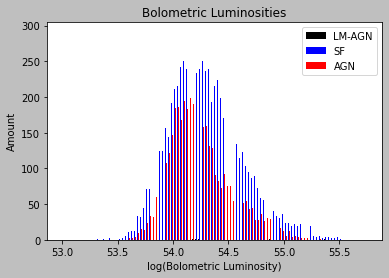

In [25]:
plt.style.use('grayscale')
bins = np.linspace(53, 55.75, 100)
colors = ['k', 'b', 'r']
plt.hist([log_bolometric_lowmetagn, log_bolometric_sf, log_bolometric_agn], bins, label=['LM-AGN', 'SF', 'AGN'], color=colors)

plt.legend(loc='upper right')
plt.title('Bolometric Luminosities')
plt.xlabel('log(Bolometric Luminosity)')
plt.ylabel('Amount')
plt.show()

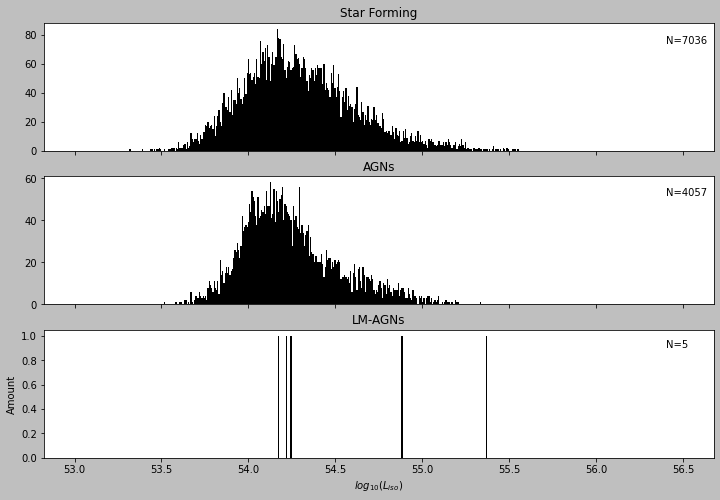

In [53]:
plt.style.use('grayscale')
fig, axs = plt.subplots(3, sharex=True, sharey=False, figsize=(12, 8))
bins = np.linspace(53, 56.5, 500)

sf_hist = axs[0].hist(log_bolometric_sf, bins=bins)
axs[0].set_title('Star Forming')
agn_hist = axs[1].hist(log_bolometric_agn, bins=bins)
axs[1].set_title('AGNs')
lm_agn_hist = axs[2].hist(log_bolometric_lowmetagn, bins=bins)
axs[2].set_title('LM-AGNs')

plt.text(56.4, 3.4, 'N=7036')
plt.text(56.4, 2.15, 'N=4057')
plt.text(56.4, 0.9, 'N=5')

plt.xlabel(r'$log_{10}(L_{iso})$')
plt.ylabel('Amount')
plt.show()

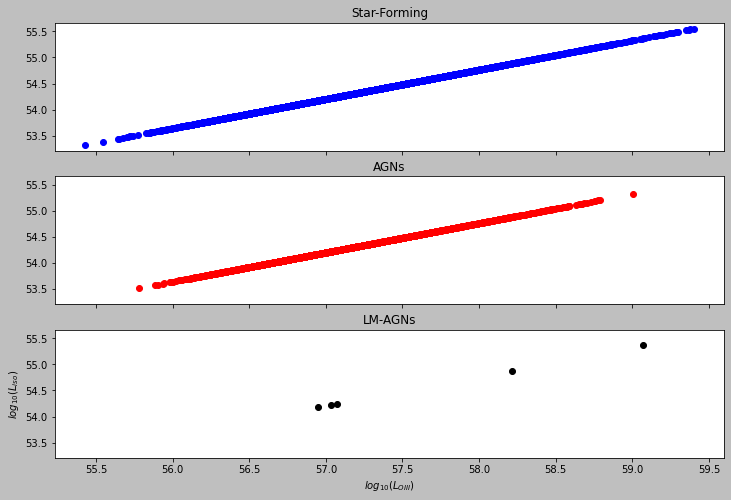

In [27]:
plt.style.use('grayscale')
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(12, 8))

sf_scatter = axs[0].scatter(dfsf['log(o3_lumin)'], dfsf['log(bolo_lumin)'], c='b')
axs[0].set_title('Star-Forming')
agn_scatter = axs[1].scatter(dfagn['log(o3_lumin)'], dfagn['log(bolo_lumin)'], c='r')
axs[1].set_title('AGNs')
lm_agn_scatter = axs[2].scatter(dflowmetagn['log(o3_lumin)'], dflowmetagn['log(bolo_lumin)'], c='k')
axs[2].set_title('LM-AGNs')

plt.ylabel(r'$log_{10}(L_{iso})$')
plt.xlabel(r'$log_{10}(L_{OIII})$')
plt.show()